# Nairobi Economic Inequality Spatial Analysis

1. Overview
2. Data Sources and Setup
3. Load and Inspect Spatial Data
4. Spatial Join and Aggregation
5. Compute and Visualize Building Density
6. Load and Inspect Wealth and Other Spatial Data
7. Aggregate RWI to Wards
8. Correlation Analysis: Building Density vs. RWI
9. Infrastructure Access (Distance to Railways and Waterways)
10. Explore Variable Relationships (Pairplot of All Variables)
11. Composite Vulnerability Score and Visualize Vulnerability Map
12. Conclusion
13. Next Steps and Limitations

## 1. Overview

This notebook explores intra-urban economic inequality in Nairobi using open geospatial data. 
We use building density as proxies for poverty concentration and service accessibility.

## 2. Data Sources and Setup

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import seaborn as sns

# Path setting
BUILDINGS_PATH = "../data/raw/kenya-latest-free.shp/gis_osm_buildings_a_free_1.shp"
WARDS_PATH = "../data/raw/kenya_wards/Kenya_Wards/kenya_wards.shp"
POP_TIF_PATH = "../data/raw/ken_ppp_2020_UNadj_constrained.tif"
BUILDING_DENSITY_MAP_PATH = "../imgs/building_density_by_ward_map.png"
BUILDING_DENSITY_PATH = "../data/processed/wards_with_building_density.shp"
RWI_CSV_PATH = "../data/raw/ken_relative_wealth_index.csv"
RAILWAYS_PATH = "../data/raw/kenya-latest-free.shp/gis_osm_railways_free_1.shp"
WATERWAYS_PATH = "../data/raw/kenya-latest-free.shp/gis_osm_waterways_free_1.shp"
BUILDING_DENSITY_RWI_PLOT_PATH = "../imgs/building_density_vs_rwi.png"
PAIRPLOT_PATH = "../imgs/pairplot_of_all_variables.png"
VULNERABILITY_PATH = "../data/processed/nairobi_vulnerability_score.shp"
VULNERABILITY_MAP_PATH = "../imgs/vulnerability_map.png"

## 3. Load and Inspect Spatial Data
We will load building count and ward boundaries.

In [2]:
buildings = gpd.read_file(BUILDINGS_PATH)
wards = gpd.read_file(WARDS_PATH)

In [3]:
print("buildings size: ", buildings.size)
print("wards size: ", wards.size)

buildings size:  42588462
wards size:  13050


In [4]:
buildings.head()

,osm_id,code,fclass,name,type,geometry
0,25341905,1500,building,None,None,"POLYGON ((36.76929 -1.23509, 36.7693 -1.23503,..."
1,26772773,1500,building,Yaya Centre,None,"POLYGON ((36.78744 -1.2929, 36.78778 -1.29278,..."
2,26952440,1500,building,Block A,None,"POLYGON ((36.81298 -1.23208, 36.81298 -1.23207..."
3,26952799,1500,building,Block B,None,"POLYGON ((36.81359 -1.23208, 36.81408 -1.23182..."
4,26952817,1500,building,Block C,None,"POLYGON ((36.81409 -1.23178, 36.81436 -1.23125..."


In [5]:
wards.head()

,gid,pop2009,county,subcounty,ward,uid,scuid,cuid,geometry
0,241,17431.0,ISIOLO,Isiolo Sub County,WABERA,rIdiIpv9fBt,I2LYLqKU6AW,bzOfj0iwfDH,"POLYGON ((37.59968 0.40029, 37.59976 0.40004, ..."
1,1455,18755.0,Migori,Rongo Sub County,North Kamagambo Ward,QC41mItjIzF,fT37q3rXQ35,fVra3Pwta0Q,"POLYGON ((34.59938 -0.65054, 34.60006 -0.65069..."
2,1456,27756.0,Migori,Rongo Sub County,Central Kamagambo Ward,M8rGveWTIMm,fT37q3rXQ35,fVra3Pwta0Q,"POLYGON ((34.61175 -0.73357, 34.61183 -0.73357..."
3,1457,27179.0,Migori,Rongo Sub County,South Kamagambo Ward,DABObbHgPMX,fT37q3rXQ35,fVra3Pwta0Q,"POLYGON ((34.61751 -0.87293, 34.6175 -0.87294,..."
4,1458,22874.0,Migori,Awendo Sub County,North Sakwa Ward,EmSsP2C6A3h,ka9Uv3Ckcbd,fVra3Pwta0Q,"POLYGON ((34.55349 -0.75193, 34.55364 -0.75195..."


## 4. Spatial Join and Aggregation

In [6]:
# Assign buildings to each administrative district with spatial coupling
joined = gpd.sjoin(buildings, wards, predicate='within')

In [7]:
joined.head()

,osm_id,code,fclass,name,type,geometry,index_right,gid,pop2009,county,subcounty,ward,uid,scuid,cuid
0,25341905,1500,building,None,None,"POLYGON ((36.76929 -1.23509, 36.7693 -1.23503,...",1162,2009,26453.0,Nairobi,Westlands Sub County,Karura Ward,CNKaaMOOKGn,f1T0Ltob8VQ,jkG3zaihdSs
1,26772773,1500,building,Yaya Centre,None,"POLYGON ((36.78744 -1.2929, 36.78778 -1.29278,...",921,2012,43122.0,Nairobi,Dagoretti North Sub County,Kilimani Ward,yXbOIljEz90,CcTr4bcVGAG,jkG3zaihdSs
2,26952440,1500,building,Block A,None,"POLYGON ((36.81298 -1.23208, 36.81298 -1.23207...",1162,2009,26453.0,Nairobi,Westlands Sub County,Karura Ward,CNKaaMOOKGn,f1T0Ltob8VQ,jkG3zaihdSs
3,26952799,1500,building,Block B,None,"POLYGON ((36.81359 -1.23208, 36.81408 -1.23182...",1162,2009,26453.0,Nairobi,Westlands Sub County,Karura Ward,CNKaaMOOKGn,f1T0Ltob8VQ,jkG3zaihdSs
4,26952817,1500,building,Block C,None,"POLYGON ((36.81409 -1.23178, 36.81436 -1.23125...",1162,2009,26453.0,Nairobi,Westlands Sub County,Karura Ward,CNKaaMOOKGn,f1T0Ltob8VQ,jkG3zaihdSs


In [8]:
# Number of buildings counted by ward
building_density = joined.groupby("ward").size().reset_index(name="building_count")

In [9]:
building_density.head()

,ward,building_count
0,ADEMASAJIDE Ward,4709
1,ARABIA,77
2,Abakaile Ward,3871
3,Abogeta east Ward,26
4,Abogeta west Ward,26


In [10]:
# Merge to original polygon
wards = wards.merge(building_density, on="ward", how="left").fillna(0)

In [11]:
print("wards:", wards.size)
wards.head()

wards: 14500


,gid,pop2009,county,subcounty,ward,uid,scuid,cuid,geometry,building_count
0,241,17431.0,ISIOLO,Isiolo Sub County,WABERA,rIdiIpv9fBt,I2LYLqKU6AW,bzOfj0iwfDH,"POLYGON ((37.59968 0.40029, 37.59976 0.40004, ...",13018.0
1,1455,18755.0,Migori,Rongo Sub County,North Kamagambo Ward,QC41mItjIzF,fT37q3rXQ35,fVra3Pwta0Q,"POLYGON ((34.59938 -0.65054, 34.60006 -0.65069...",7104.0
2,1456,27756.0,Migori,Rongo Sub County,Central Kamagambo Ward,M8rGveWTIMm,fT37q3rXQ35,fVra3Pwta0Q,"POLYGON ((34.61175 -0.73357, 34.61183 -0.73357...",8463.0
3,1457,27179.0,Migori,Rongo Sub County,South Kamagambo Ward,DABObbHgPMX,fT37q3rXQ35,fVra3Pwta0Q,"POLYGON ((34.61751 -0.87293, 34.6175 -0.87294,...",9189.0
4,1458,22874.0,Migori,Awendo Sub County,North Sakwa Ward,EmSsP2C6A3h,ka9Uv3Ckcbd,fVra3Pwta0Q,"POLYGON ((34.55349 -0.75193, 34.55364 -0.75195...",15753.0


## 5. Compute and Visualize Building Density

In [12]:
# Calculate density by converting area to square km
wards["area_km2"] = wards.geometry.to_crs(epsg=3395).area / 1e6

In [13]:
wards["buildings_per_km2"] = wards["building_count"] / wards["area_km2"]

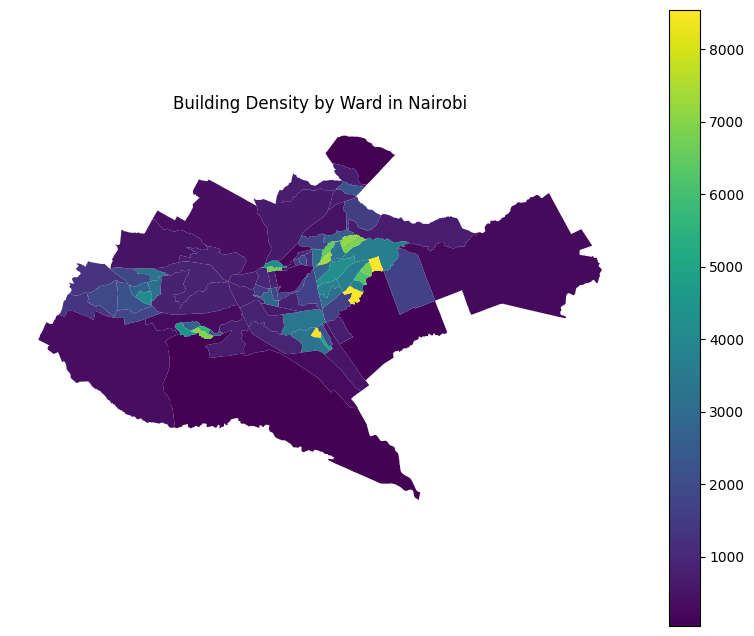

In [14]:
# choropleth map of building density
wards[wards["county"]=="Nairobi"].plot(column="buildings_per_km2", cmap="viridis", legend=True, figsize=(10, 8))
plt.title("Building Density by Ward in Nairobi")
plt.axis("off")
plt.savefig(BUILDING_DENSITY_MAP_PATH)
plt.show()

In [15]:
wards.sort_values("buildings_per_km2", ascending=False).head()

,gid,pop2009,county,subcounty,ward,uid,scuid,cuid,geometry,building_count,area_km2,buildings_per_km2
1301,2245,44760.0,Kiambu,Ruiru Sub County,Mwiki Ward,KoIp1GKz0UI,TPRNJqSm4lK,qKzosKQPl6G,"POLYGON ((36.92262 -1.20812, 36.92288 -1.20853...",13141.0,1.486637,8839.416913
1219,2061,14930.0,Nairobi,Embakasi Central Sub County,Matopeni/spring Valley Ward,xhXsdnqx3eX,XvpLXU47BKs,jkG3zaihdSs,"POLYGON ((36.93066 -1.2565, 36.93083 -1.2569, ...",8766.0,1.026510,8539.615742
1221,2062,45137.0,Nairobi,Embakasi East Sub County,Upper Savanna Ward,OaqOHmb6jNs,gD4xxgDGJ4Y,jkG3zaihdSs,"POLYGON ((36.91258 -1.28067, 36.91265 -1.28069...",11250.0,1.319781,8524.144050
1206,2049,26015.0,Nairobi,Embakasi South Sub County,Kwa Reuben Ward,HvcGWkiIxjp,aDp1odOWYC1,jkG3zaihdSs,"POLYGON ((36.88241 -1.31071, 36.88242 -1.31075...",3951.0,0.468805,8427.819744
1210,2053,22802.0,Nairobi,Embakasi North Sub County,Dandora Area I Ward,Qusks6YHAmd,SSz1iOv28Jk,jkG3zaihdSs,"POLYGON ((36.89252 -1.25308, 36.89252 -1.25308...",4318.0,0.585834,7370.683921


In [16]:
# Export Processed Data for QGIS
wards[wards["county"]=="Nairobi"].to_file(BUILDING_DENSITY_PATH)

C:\Users\user\AppData\Local\Temp\ipykernel_5736\3752909562.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wards[wards["county"]=="Nairobi"].to_file(BUILDING_DENSITY_PATH)
C:\Users\user\anaconda3\envs\poverty-inequality-nairobi\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'building_count' to 'building_c'
  ogr_write(
C:\Users\user\anaconda3\envs\poverty-inequality-nairobi\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'buildings_per_km2' to 'buildings_'
  ogr_write(


## 6. Load and Inspect Wealth and Other Spatial Data
We will load building density, ward boundaries, RWI point data (from CSV), and infrastructure layers (railways, waterways).

In [17]:
# Load ward shapefile with building density already computed
wards = gpd.read_file(BUILDING_DENSITY_PATH)
wards = wards.rename(columns={'buildings_': 'buildings_per_km2'})
print("wards size: ", wards.size)

wards size:  1020


In [18]:
# Load RWI point data from CSV and convert to GeoDataFrame
rwi_df = pd.read_csv(RWI_CSV_PATH)
rwi_gdf = gpd.GeoDataFrame(
    rwi_df,
    geometry=gpd.points_from_xy(rwi_df.longitude, rwi_df.latitude),
    crs="EPSG:4326"
).to_crs(wards.crs)

# Load infrastructure layers
railways = gpd.read_file(RAILWAYS_PATH).to_crs(wards.crs)
waterways = gpd.read_file(WATERWAYS_PATH).to_crs(wards.crs)

## 7. Aggregate RWI to Wards
We calculate the average RWI score for each administrative ward by spatially joining point-based wealth scores.

In [19]:
# Spatial join: assign each RWI point to a ward
rwi_joined = gpd.sjoin(rwi_gdf, wards, how="inner", predicate="within")

In [20]:
rwi_joined.head()

,latitude,longitude,rwi,error,geometry,index_right,gid,pop2009,county,subcounty,ward,uid,scuid,cuid,building_c,area_km2,buildings_per_km2
513,-1.241358,36.815185,0.752,0.528,POINT (36.81519 -1.24136),31,2009,26453.0,Nairobi,Westlands Sub County,Karura Ward,CNKaaMOOKGn,f1T0Ltob8VQ,jkG3zaihdSs,13657.0,38.132786,358.143255
933,-1.285293,36.815185,1.304,0.507,POINT (36.81519 -1.28529),3,2012,43122.0,Nairobi,Dagoretti North Sub County,Kilimani Ward,yXbOIljEz90,CcTr4bcVGAG,jkG3zaihdSs,13384.0,16.057518,833.503663
1269,-1.307260,36.925049,1.013,0.541,POINT (36.92505 -1.30726),14,2064,34084.0,Nairobi,Embakasi East Sub County,Embakasi Ward,raV5YKTRCG2,gD4xxgDGJ4Y,jkG3zaihdSs,3755.0,42.268301,88.837258
1332,-1.219390,36.837158,0.904,0.521,POINT (36.83716 -1.21939),7,2035,40331.0,Nairobi,Roysambu Sub County,Roysambu Ward,RRAEO9Ltfec,j7GpbairCOi,jkG3zaihdSs,13877.0,22.364339,620.496752
1489,-1.241358,36.990967,0.538,0.488,POINT (36.99097 -1.24136),8,2038,39156.0,Nairobi,Kasarani Sub County,Mwiki Ward,LWZoX1NZFa1,FoqzDgIByL6,jkG3zaihdSs,13141.0,18.786667,699.485420


In [21]:
# Calculate mean RWI per ward
mean_rwi = rwi_joined.groupby("ward")["rwi"].mean().reset_index(name="mean_rwi")

In [22]:
mean_rwi.head()

,ward,mean_rwi
0,Babandogo,1.283000
1,Clay City,1.200000
2,Dandora Area Iv Ward,0.729000
3,Eastleigh South Ward,0.759000
4,Embakasi Ward,0.531833


In [23]:
# Merge with wards GeoDataFrame
wards = wards.merge(mean_rwi, on="ward", how="left")

In [24]:
wards.head()

,gid,pop2009,county,subcounty,ward,uid,scuid,cuid,building_c,area_km2,buildings_per_km2,geometry,mean_rwi
0,2044,55158.0,Nairobi,Ruaraka Sub County,Mathare North Ward,dOQTHZsuaIb,Cc8uEFkzfVf,jkG3zaihdSs,483.0,0.463493,1042.086230,"POLYGON ((36.87653 -1.2521, 36.87618 -1.25223,...",NaN
1,2047,70641.0,Nairobi,Embakasi South Sub County,Imara Daima Ward,Nt7PPe0Vdou,aDp1odOWYC1,jkG3zaihdSs,12868.0,3.914182,3287.532330,"POLYGON ((36.87934 -1.31037, 36.87934 -1.31037...",NaN
2,2008,38384.0,Nairobi,Westlands Sub County,Parklands/highridge Ward,QhDd2LAuXAF,f1T0Ltob8VQ,jkG3zaihdSs,6102.0,8.179268,746.032533,"POLYGON ((36.80712 -1.24986, 36.80714 -1.24988...",1.235000
3,2012,43122.0,Nairobi,Dagoretti North Sub County,Kilimani Ward,yXbOIljEz90,CcTr4bcVGAG,jkG3zaihdSs,13384.0,16.057518,833.503663,"POLYGON ((36.7825 -1.26623, 36.78235 -1.2667, ...",1.393000
4,2015,27202.0,Nairobi,Dagoretti North Sub County,Kileleshwa Ward,DnVTXbCnup5,CcTr4bcVGAG,jkG3zaihdSs,7687.0,9.037454,850.571389,"POLYGON ((36.78027 -1.25888, 36.78131 -1.259, ...",1.286333


## 8. Correlation Analysis: Building Density vs. RWI
We use a scatterplot and correlation coefficient to assess whether denser areas are poorer (lower RWI).

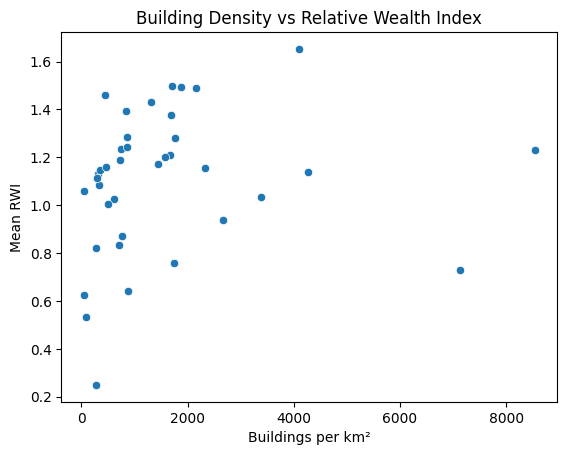

                   buildings_per_km2  mean_rwi
buildings_per_km2           1.000000  0.158143
mean_rwi                    0.158143  1.000000


In [25]:
# Scatter plot
sns.scatterplot(data=wards, x="buildings_per_km2", y="mean_rwi")
plt.title("Building Density vs Relative Wealth Index")
plt.xlabel("Buildings per km²")
plt.ylabel("Mean RWI")
plt.savefig(BUILDING_DENSITY_RWI_PLOT_PATH)
plt.show()

# Pearson correlation
print(wards[["buildings_per_km2", "mean_rwi"]].corr())

## 9. Infrastructure Access (Distance to Railways and Waterways)
We compute the minimum distance from each ward to the nearest railway and waterway as proxies for physical accessibility.

In [26]:
# Calculate ward centroids
wards["centroid"] = wards.geometry.centroid

# Distance to nearest railway and waterway (in km)
wards["dist_to_rail_km"] = wards["centroid"].apply(lambda x: railways.distance(x).min() / 1000)
wards["dist_to_water_km"] = wards["centroid"].apply(lambda x: waterways.distance(x).min() / 1000)

C:\Users\user\AppData\Local\Temp\ipykernel_5736\3912689148.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wards["centroid"] = wards.geometry.centroid
C:\Users\user\AppData\Local\Temp\ipykernel_5736\3912689148.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wards["dist_to_rail_km"] = wards["centroid"].apply(lambda x: railways.distance(x).min() / 1000)
C:\Users\user\AppData\Local\Temp\ipykernel_5736\3912689148.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wards["dist_to_water_km"] = wards["centroid"].apply(lambda x: waterways.distance(x).min() / 1000)


In [27]:
wards.head()

,gid,pop2009,county,subcounty,ward,uid,scuid,cuid,building_c,area_km2,buildings_per_km2,geometry,mean_rwi,centroid,dist_to_rail_km,dist_to_water_km
0,2044,55158.0,Nairobi,Ruaraka Sub County,Mathare North Ward,dOQTHZsuaIb,Cc8uEFkzfVf,jkG3zaihdSs,483.0,0.463493,1042.086230,"POLYGON ((36.87653 -1.2521, 36.87618 -1.25223,...",NaN,POINT (36.87065 -1.25326),0.000023,9.232786e-07
1,2047,70641.0,Nairobi,Embakasi South Sub County,Imara Daima Ward,Nt7PPe0Vdou,aDp1odOWYC1,jkG3zaihdSs,12868.0,3.914182,3287.532330,"POLYGON ((36.87934 -1.31037, 36.87934 -1.31037...",NaN,POINT (36.87683 -1.32129),0.000002,8.845522e-06
2,2008,38384.0,Nairobi,Westlands Sub County,Parklands/highridge Ward,QhDd2LAuXAF,f1T0Ltob8VQ,jkG3zaihdSs,6102.0,8.179268,746.032533,"POLYGON ((36.80712 -1.24986, 36.80714 -1.24988...",1.235000,POINT (36.80485 -1.25874),0.000039,2.260488e-07
3,2012,43122.0,Nairobi,Dagoretti North Sub County,Kilimani Ward,yXbOIljEz90,CcTr4bcVGAG,jkG3zaihdSs,13384.0,16.057518,833.503663,"POLYGON ((36.7825 -1.26623, 36.78235 -1.2667, ...",1.393000,POINT (36.78482 -1.28662),0.000022,1.207964e-06
4,2015,27202.0,Nairobi,Dagoretti North Sub County,Kileleshwa Ward,DnVTXbCnup5,CcTr4bcVGAG,jkG3zaihdSs,7687.0,9.037454,850.571389,"POLYGON ((36.78027 -1.25888, 36.78131 -1.259, ...",1.286333,POINT (36.78547 -1.27177),0.000036,2.471303e-06


## 10. Explore Variable Relationships (Pairplot of All Variables)
We use pairplots to examine interactions between wealth, density, and access to infrastructure.

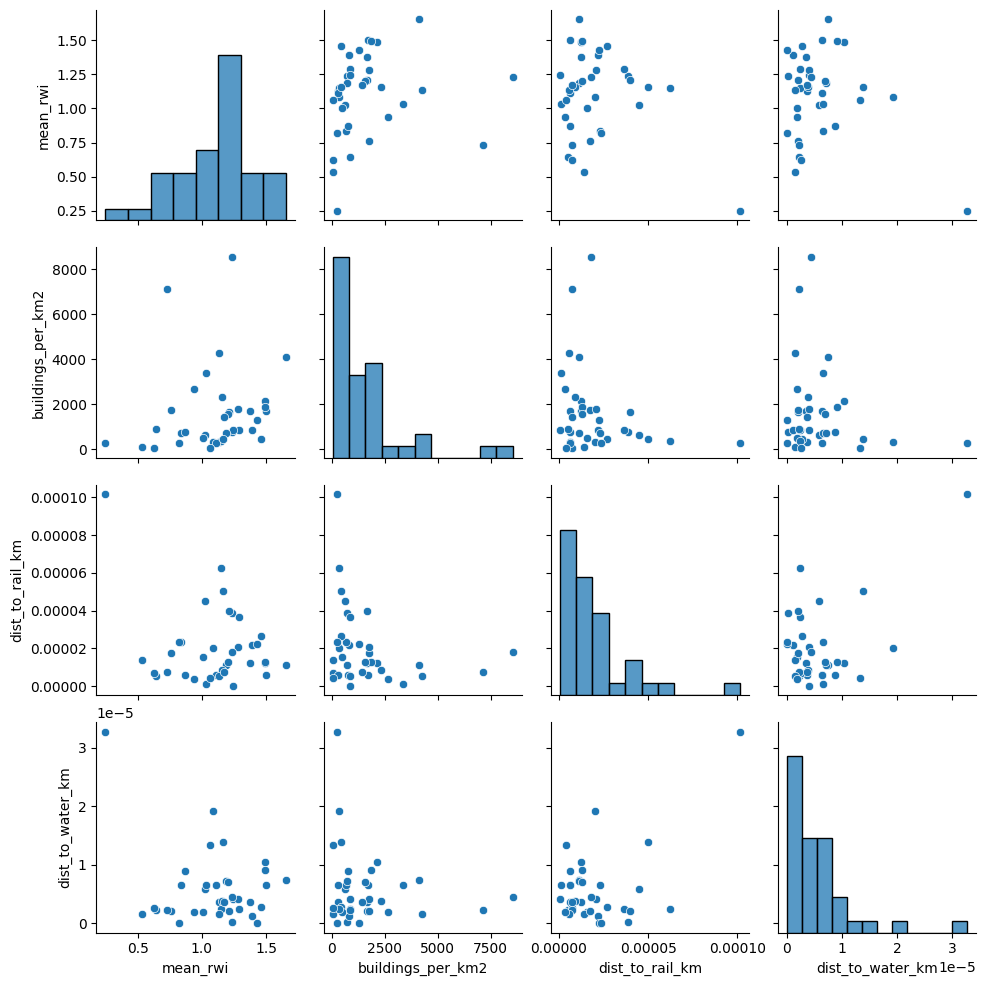

In [28]:
sns.pairplot(wards[["mean_rwi", "buildings_per_km2", "dist_to_rail_km", "dist_to_water_km"]].dropna())
plt.savefig(PAIRPLOT_PATH)
plt.show()

## 11. Composite Vulnerability Score and Visualize Vulnerability Map
We highlight the wards that are densely built-up but relatively poorer using a custom vulnerability score.

In [29]:
# Rank variables for normalization (0 to 1)
wards["density_rank"] = wards["buildings_per_km2"].rank(pct=True)
wards["rwi_rank"] = wards["mean_rwi"].rank(pct=True)

# Vulnerability = high density × low RWI
wards["vulnerability_score"] = wards["density_rank"] * (1 - wards["rwi_rank"])

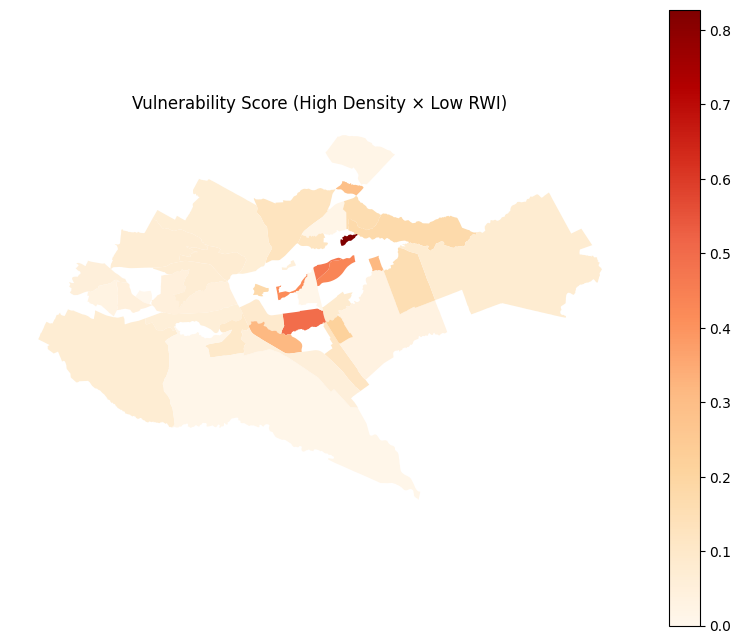

In [32]:
wards.plot(column="vulnerability_score", cmap="OrRd", legend=True, figsize=(10, 8))
plt.title("Vulnerability Score (High Density × Low RWI)")
plt.axis("off")
plt.savefig(VULNERABILITY_MAP_PATH)
plt.show()

In [33]:
# Export Processed Data for QGIS
del wards["centroid"]
wards.to_file(VULNERABILITY_PATH)

C:\Users\user\AppData\Local\Temp\ipykernel_5736\909822336.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wards.to_file(VULNERABILITY_PATH)
C:\Users\user\anaconda3\envs\poverty-inequality-nairobi\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'buildings_per_km2' to 'buildings_'
  ogr_write(
C:\Users\user\anaconda3\envs\poverty-inequality-nairobi\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'dist_to_rail_km' to 'dist_to_ra'
  ogr_write(
C:\Users\user\anaconda3\envs\poverty-inequality-nairobi\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'dist_to_water_km' to 'dist_to_wa'
  ogr_write(
C:\Users\user\anaconda3\envs\poverty-inequality-nairobi\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'density_rank' to 'density_ra'
  ogr_write(
C:\Users\user\anaconda3\envs\poverty-ine

In [34]:
# TOP5 vulnerable area
wards.sort_values("vulnerability_score", ascending=False).head()[['subcounty','ward']]

,subcounty,ward
52,Embakasi North Sub County,Dandora Area Iv Ward
17,Makadara Sub County,Viwandani Ward
70,Embakasi West Sub County,Kariobangi South Ward
69,Embakasi West Sub County,Mowlem Ward
19,Kamukunji Sub County,Eastleigh South Ward


## 12. Conclusion
### Summary of results
- High building density subcounties in Nairobi belong to Embakasi.
- Most of the estimated vulnerable counties also belong to Embakasi. Top vulnerable area is Dandora in Embakasi.
- Overlaying the maps of vulnerable areas and building density revealed a tendency for the more vulnerable areas to be those with higher building densities.
### Discussion
- Embakasi is the most populated in Nairobi City County. The density of buildings would reflect high population density.
- Railways and waterways often run along Embakasi sub country borders and accessibility to infrastructure is not good.
- High population and building density despite low accessibility would result in a high estimated vulnerability of Embakasi.
- Specifically, Dandora's surrounding neighbourhoods include slums, which validates that Dandora is estimated as the most vulnerable area.
### Remarks
- This notebook demonstrates how to combine proxy indicator of buildings, wealth, and infrastructure accessibility to highlight spatial inequality in Nairobi.
- Even with limited data, meaningful insights can be derived using geospatial techniques.

## 13. Next Steps and Limitations

- Add population raster zonal statistics using rasterstats
- Integrate OSM amenities (schools, hospitals)
- Compute service accessibility metrics
- Consider using night-time light data as another proxy

**Limitations:**
- Building footprints may not perfectly reflect actual density
- No direct income data; all indicators are proxies